In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import requests
import csv
import json
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim 
from geopy.exc import GeocoderTimedOut
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
print('Libraries imported.')

Libraries imported.


In [2]:
melbourne_suburbs = pd.read_csv('melbourne_suburbs.csv')
real_estate=pd.read_csv('real_estate_combined.csv')
melbourne_suburbs=melbourne_suburbs.fillna(0)
melbourne_suburbs.reset_index(inplace=True)
melbourne_suburbs.drop(['index'],inplace=True,axis=1)
# melbourne_suburbs[['Population','Postcode','Density','Latitude','Longitude']]=melbourne_suburbs[['Population','Postcode','Density','Latitude','Longitude']].apply(pd.to_numeric)
melbourne_suburbs

,Suburb,Postcode,Latitude,Longitude,Population,Density
0,"Abbotsford, Victoria",3067.0,-37.800278,145.000000,8184.0,4550.0
1,"Aberfeldie, Victoria",3040.0,-37.751111,144.900000,3897.0,2482.0
2,"Aintree, Victoria",3336.0,-37.716667,144.666667,0.0,0.0
3,"Airport West, Victoria",3042.0,-37.717222,144.867778,7564.0,2044.0
4,"Albanvale, Victoria",3021.0,-37.734444,144.751389,5491.0,2700.0
...,...,...,...,...,...,...
381,"Windsor, Victoria",3181.0,-37.850278,144.983611,7281.0,7000.0
382,"Wollert, Victoria",3750.0,-37.584444,145.018056,9060.0,0.0
383,Wyndham Vale,3024.0,-37.883889,144.617778,23273.0,7510.0
384,"Yallambie, Victoria",3085.0,-37.717500,145.100278,4117.0,1328.0


In [3]:
melbourne_stations=pd.read_csv("melbourne_stations.csv")
melbourne_stations.dropna(inplace=True)
melbourne_stations.reset_index(inplace=True)
melbourne_stations.drop(['index'],inplace=True,axis=1)
# melbourne_stations[['Latitude','Longitude']]=melbourne_suburbs[['Latitude','Longitude']].apply(pd.to_numeric)
melbourne_stations

,Station,Latitude,Longitude
0,Southern Cross,-37.818333,144.952500
1,Aircraft,-37.866667,144.760833
2,Alamein,-37.868333,145.079722
3,Albion,-37.777222,144.824444
4,Alphington,-37.778333,145.031389
...,...,...,...
215,Williamstown Beach,-37.864167,144.894444
216,Willison,-37.835833,145.070278
217,Windsor,-37.856111,144.991944
218,Yarraman,-37.978056,145.191389


In [4]:
#Obtain the latitude and longitude of Sydney
address = 'Melbourne, Australia'
try:
    geolocator = Nominatim(user_agent="Melbourne_explorer")
except:
    pass
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Melbourne are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Melbourne are -37.8142176, 144.9631608.


###### Visualization of the two data sets obtained above by plotting them on a map.

In [5]:
map_melbourne = folium.Map(location=[latitude, longitude], zoom_start=8.5)

for lat, lng, suburb in zip(melbourne_suburbs['Latitude'], melbourne_suburbs['Longitude'], melbourne_suburbs['Suburb']):
    label = '{}'.format(suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
        radius=3,
        popup=label,
        color='#1E90FF',
        fill=True,
        fill_color='#00BFFF',
        fill_opacity=0.8,
        parse_html=False).add_to(map_melbourne)  

for lat, lng, station in zip(melbourne_stations['Latitude'], melbourne_stations['Longitude'], melbourne_stations['Station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
        radius=4,
        popup=label,
        color='#008000',
        fill=True,
        fill_color='#3CB371	',
        fill_opacity=0.8,
        parse_html=False).add_to(map_melbourne)  
legend_html =   '''
                <div style="position: absolute; 
                            bottom: 50px; left: 50px; width: 170px; height: 50px; 
                            border:2px solid grey; z-index:9999; font-size:18px;font-weight:500%;
                            ">
                              &nbsp; Train Network &nbsp; <i class="fa fa-circle fa-x" style="color:#3CB371"></i><br>
                              &nbsp; Suburbs       &nbsp; <i class="fa fa-circle fa-x" style="color:#1E90FF"></i>
                </div>
                '''               
map_melbourne.get_root().html.add_child(folium.Element(legend_html))    
map_melbourne

<h1>1. Finding Nearest Railway Station</h1>

In [6]:
from geopy.distance import great_circle
a=len(melbourne_suburbs)
nearest_station=[None] * a
distance= [None] * a

for i in range(a):
    if (melbourne_suburbs['Latitude'][i]!=0):
        suburb_coor=(melbourne_suburbs['Latitude'][i],melbourne_suburbs['Longitude'][i])
        dist=float('inf')
        for j in range(len(melbourne_stations)):
            station_coor=(melbourne_stations['Latitude'][j],melbourne_stations['Longitude'][j])
            temp=great_circle(suburb_coor,station_coor).km
            if(temp<dist):
                dist = temp
                distance[i] = temp
                nearest_station[i]=melbourne_stations['Station'][j]
    else:
        nearest_station[i]=np.nan
        distance[i]=np.nan

In [7]:
melbourne_suburbs_station=pd.DataFrame(melbourne_suburbs[['Suburb','Latitude','Longitude']])
melbourne_suburbs_station.insert(1,'Nearest Train Station',nearest_station)
melbourne_suburbs_station.insert(2,'Distance(km)',distance)
melbourne_suburbs_station.dropna(inplace=True)
melbourne_suburbs_station.reset_index(drop=True, inplace=True)
melbourne_suburbs_station

,Suburb,Nearest Train Station,Distance(km),Latitude,Longitude
0,"Abbotsford, Victoria",Victoria Park,0.503514,-37.800278,145.000000
1,"Aberfeldie, Victoria",Essendon,1.521641,-37.751111,144.900000
2,"Aintree, Victoria",Watergardens,9.595217,-37.716667,144.666667
3,"Airport West, Victoria",Glenroy,4.566174,-37.717222,144.867778
4,"Albanvale, Victoria",Keilor Plains,3.778670,-37.734444,144.751389
...,...,...,...,...,...
376,"Windsor, Victoria",Prahran,0.568560,-37.850278,144.983611
377,"Wollert, Victoria",Craigieburn,6.915282,-37.584444,145.018056
378,Wyndham Vale,Werribee,4.177509,-37.883889,144.617778
379,"Yallambie, Victoria",Watsonia,1.607158,-37.717500,145.100278


### Clustering the Suburb to station distance

In [8]:
clustering = pd.DataFrame(columns=['Distance(km)'])
clustering['Distance(km)'] = melbourne_suburbs_station['Distance(km)']
kmeans = KMeans(n_clusters=5).fit(clustering)
clusters = kmeans.labels_

In [9]:
melbourne_suburbs_station.insert(loc=3,column="Cluster_Labels_Dist",value=clusters) 
melbourne_suburbs_station

,Suburb,Nearest Train Station,Distance(km),Cluster_Labels_Dist,Latitude,Longitude
0,"Abbotsford, Victoria",Victoria Park,0.503514,4,-37.800278,145.000000
1,"Aberfeldie, Victoria",Essendon,1.521641,4,-37.751111,144.900000
2,"Aintree, Victoria",Watergardens,9.595217,2,-37.716667,144.666667
3,"Airport West, Victoria",Glenroy,4.566174,0,-37.717222,144.867778
4,"Albanvale, Victoria",Keilor Plains,3.778670,0,-37.734444,144.751389
...,...,...,...,...,...,...
376,"Windsor, Victoria",Prahran,0.568560,4,-37.850278,144.983611
377,"Wollert, Victoria",Craigieburn,6.915282,2,-37.584444,145.018056
378,Wyndham Vale,Werribee,4.177509,0,-37.883889,144.617778
379,"Yallambie, Victoria",Watsonia,1.607158,4,-37.717500,145.100278


### Analysis

In [10]:
melbourne_suburbs_station['Distance(km)'].describe()

count    381.000000
mean       3.437843
std        5.542316
min        0.024374
25%        0.919056
50%        1.703369
75%        3.412404
max       41.665202
Name: Distance(km), dtype: float64

In [11]:
melbourne_suburbs_station['Cluster_Labels_Dist'].value_counts()

4    214
0    103
2     37
3     20
1      7
Name: Cluster_Labels_Dist, dtype: int64

### Seperating the Clusters 

In [12]:
cluster_0_dist = pd.DataFrame()
cluster_0_dist = melbourne_suburbs_station.loc[(melbourne_suburbs_station['Cluster_Labels_Dist'] == 0)]
describe_0_dist = cluster_0_dist['Distance(km)'].describe()

In [13]:
cluster_1_dist = pd.DataFrame()
cluster_1_dist = melbourne_suburbs_station.loc[(melbourne_suburbs_station['Cluster_Labels_Dist'] == 1)]
describe_1_dist = cluster_1_dist['Distance(km)'].describe()

In [14]:
cluster_2_dist = pd.DataFrame()
cluster_2_dist = melbourne_suburbs_station.loc[(melbourne_suburbs_station['Cluster_Labels_Dist'] == 2)]
describe_2_dist = cluster_2_dist['Distance(km)'].describe()

In [15]:
cluster_3_dist = pd.DataFrame()
cluster_3_dist = melbourne_suburbs_station.loc[(melbourne_suburbs_station['Cluster_Labels_Dist'] == 3)]
describe_3_dist = cluster_3_dist['Distance(km)'].describe()

In [16]:
cluster_4_dist = pd.DataFrame()
cluster_4_dist = melbourne_suburbs_station.loc[(melbourne_suburbs_station['Cluster_Labels_Dist'] == 4)]
describe_4_dist = cluster_4_dist['Distance(km)'].describe()

### Count and Mean of each cluster

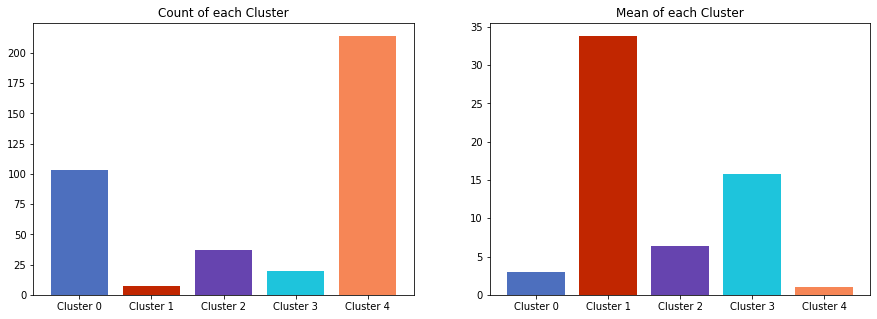

In [17]:

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.bar(['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4'],
        [describe_0_dist.iloc[0],describe_1_dist.iloc[0],describe_2_dist.iloc[0],describe_3_dist.iloc[0],describe_4_dist.iloc[0]],color=('#4d6fbe','#C12600','#6644af','#1ec4dc','#F68656'))
plt.title('Count of each Cluster')
plt.subplot(122)
plt.bar(['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4'], 
        [describe_0_dist.iloc[1],describe_1_dist.iloc[1],describe_2_dist.iloc[1],describe_3_dist.iloc[1],describe_4_dist.iloc[1]],color=('#4d6fbe','#C12600','#6644af','#1ec4dc','#F68656'))
plt.title('Mean of each Cluster')
plt.show()

### Spread of each cluster W.R.T the Train network

In [18]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8.5)

rainbow = ['#4d6fbe','#C12600','#6644af','#1ec4dc','#F68656']

for lat, lon, suburb, cluster in zip(cluster_0_dist['Latitude'], cluster_0_dist['Longitude'], cluster_0_dist['Suburb'],cluster_0_dist['Cluster_Labels_Dist']):
    label = folium.Popup(suburb + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[0],
        fill=True,
        fill_color=rainbow[0],
        fill_opacity=1).add_to(map_clusters)

for lat, lon, suburb, cluster in zip(cluster_1_dist['Latitude'], cluster_1_dist['Longitude'], cluster_1_dist['Suburb'],cluster_1_dist['Cluster_Labels_Dist']):
    label = folium.Popup(suburb + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[1],
        fill=True,
        fill_color=rainbow[1],
        fill_opacity=1).add_to(map_clusters)
           
for lat, lon, suburb, cluster in zip(cluster_2_dist['Latitude'], cluster_2_dist['Longitude'], cluster_2_dist['Suburb'],cluster_2_dist['Cluster_Labels_Dist']):
    label = folium.Popup(suburb + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[2],
        fill=True,
        fill_color=rainbow[2],
        fill_opacity=1).add_to(map_clusters)
           
for lat, lon, suburb, cluster in zip(cluster_3_dist['Latitude'], cluster_3_dist['Longitude'], cluster_3_dist['Suburb'],cluster_3_dist['Cluster_Labels_Dist']):
    label = folium.Popup(suburb + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[3],
        fill=True,
        fill_color=rainbow[3],
        legend='Cluster 3',
        fill_opacity=1).add_to(map_clusters)
       
for lat, lon, suburb, cluster in zip(cluster_4_dist['Latitude'], cluster_4_dist['Longitude'], cluster_4_dist['Suburb'],cluster_4_dist['Cluster_Labels_Dist']):
    label = folium.Popup(suburb + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[4],
        fill=True,
        fill_color=rainbow[4],
        fill_opacity=1).add_to(map_clusters)
    
for lat, lng, station in zip(melbourne_stations['Latitude'], melbourne_stations['Longitude'], melbourne_stations['Station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
        radius=3,
        popup=label,
        color='#008000',
        fill=True,
        fill_color='#3CB371	',
        fill_opacity=1,
        parse_html=False).add_to(map_clusters)  
legend_html =   '''
                <div style="position: absolute; 
                            bottom: 50px; left: 50px; width: 170px; height: 160px; 
                            border:2px solid grey; z-index:9999; font-size:18px;font-weight:500%
                            ">
                              &nbsp; Train Network &nbsp; <i class="fa fa-circle fa-x" style="color:#3CB371"></i><br>
                              &nbsp; cluster 0_dist     &nbsp; <i class="fa fa-circle fa-x" style="color:#4d6fbe"></i><br>
                              &nbsp; cluster 1_dist     &nbsp; <i class="fa fa-circle fa-x" style="color:#C12600"></i><br>
                              &nbsp; cluster 2_dist     &nbsp; <i class="fa fa-circle fa-x" style="color:#6644af"></i><br>
                              &nbsp; cluster 3_dist     &nbsp; <i class="fa fa-circle fa-x" style="color:#1ec4dc"></i><br>
                              &nbsp; cluster 4_dist     &nbsp; <i class="fa fa-circle fa-x" style="color:#F68656"></i>
                </div>
                '''               
map_clusters.get_root().html.add_child(folium.Element(legend_html))
map_clusters

### Cluster Summary

In [19]:
df_Clusters_dist=pd.DataFrame(cluster_0_dist.describe()['Distance(km)'])
df_Clusters_dist.insert(1,'Cluster 1',cluster_1_dist.describe()['Distance(km)'])
df_Clusters_dist.insert(2,'Cluster 2',cluster_2_dist.describe()['Distance(km)'])
df_Clusters_dist.insert(2,'Cluster 3',cluster_3_dist.describe()['Distance(km)'])
df_Clusters_dist.insert(4,'Cluster 4',cluster_4_dist.describe()['Distance(km)'])
df_Clusters_dist=df_Clusters_dist.rename(columns={'Distance(km)':'Cluster 0'})

In [20]:
df_Clusters_dist

,Cluster 0,Cluster 1,Cluster 3,Cluster 2,Cluster 4
count,103.000000,7.000000,20.000000,37.000000,214.000000
mean,2.992282,33.803689,15.743068,6.410271,0.995074
std,0.731445,5.167026,3.362249,1.480689,0.516406
min,2.005883,27.337069,11.149760,4.732781,0.024374
25%,2.377455,30.173898,13.389692,5.198052,0.543518
50%,2.793148,32.624368,15.678233,5.928722,0.974352
75%,3.557045,37.325695,16.905305,6.915282,1.414346
max,4.566174,41.665202,22.843996,9.916701,1.975678


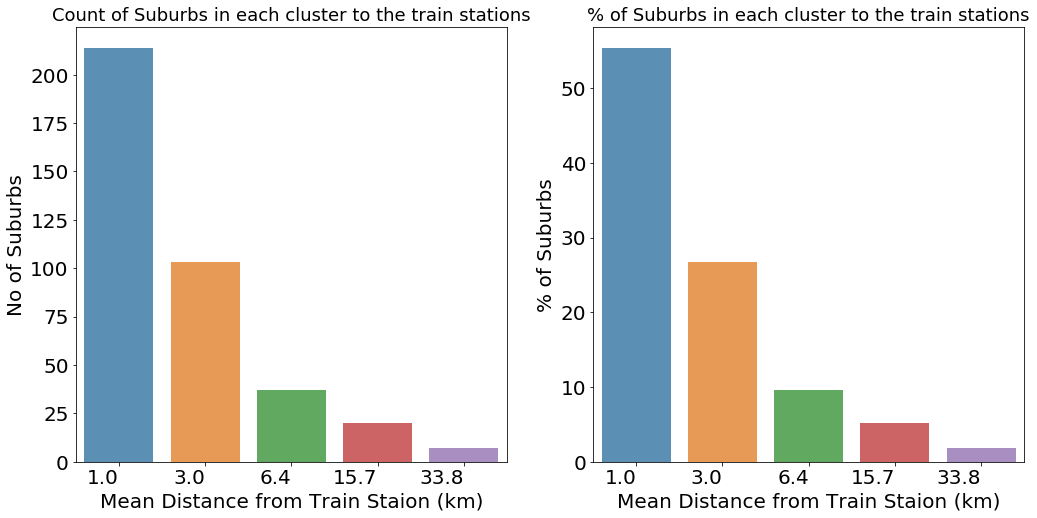

In [53]:
pd.set_option('precision', 2)
np.set_printoptions(precision=2)
np.around([0.37, 1.64], decimals=1)
df_Clusters_dist[:2]=np.around(df_Clusters_dist[:2],decimals=1)
count = df_Clusters_dist[:2].values
count[0].transpose()
plt.figure(figsize=(17,8))
plt.subplot(121)
plt.title('Count of Suburbs in each cluster to the train stations',fontsize=18)
sns.barplot(count[1].transpose(), count[0].transpose(), alpha=0.8)
plt.xlabel('Mean Distance from Train Staion (km)', fontsize=20)
plt.ylabel('No of Suburbs', fontsize=20)
plt.xticks(
    horizontalalignment='right',
    fontsize=20
)
plt.yticks(
    fontsize=20
)

plt.subplot(122)
plt.title('% of Suburbs in each cluster to the train stations',fontsize=18)
sns.barplot(count[1].transpose(), count[0].transpose()*100/len(melbourne_suburbs), alpha=0.8)
plt.xlabel('Mean Distance from Train Staion (km)', fontsize=20)
plt.ylabel('% of Suburbs', fontsize=20)
plt.xticks(
    horizontalalignment='right',
    fontsize=20
)
plt.yticks(
    fontsize=20
)

plt.show()

In [22]:
melbourne_suburbs_station_dummies = pd.get_dummies(melbourne_suburbs_station, columns=['Cluster_Labels_Dist'])
melbourne_suburbs_station_dummies

,Suburb,Nearest Train Station,Distance(km),Latitude,Longitude,Cluster_Labels_Dist_0,Cluster_Labels_Dist_1,Cluster_Labels_Dist_2,Cluster_Labels_Dist_3,Cluster_Labels_Dist_4
0,"Abbotsford, Victoria",Victoria Park,0.50,-37.80,145.00,0,0,0,0,1
1,"Aberfeldie, Victoria",Essendon,1.52,-37.75,144.90,0,0,0,0,1
2,"Aintree, Victoria",Watergardens,9.60,-37.72,144.67,0,0,1,0,0
3,"Airport West, Victoria",Glenroy,4.57,-37.72,144.87,1,0,0,0,0
4,"Albanvale, Victoria",Keilor Plains,3.78,-37.73,144.75,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
376,"Windsor, Victoria",Prahran,0.57,-37.85,144.98,0,0,0,0,1
377,"Wollert, Victoria",Craigieburn,6.92,-37.58,145.02,0,0,1,0,0
378,Wyndham Vale,Werribee,4.18,-37.88,144.62,1,0,0,0,0
379,"Yallambie, Victoria",Watsonia,1.61,-37.72,145.10,0,0,0,0,1


In [23]:
melbourne_suburbs_station_dummies_dist=melbourne_suburbs_station_dummies.copy()
melbourne_suburbs_station_dummies_dist[['Cluster_Labels_Dist_0']]=melbourne_suburbs_station_dummies_dist[['Cluster_Labels_Dist_0']].astype(float)
melbourne_suburbs_station_dummies_dist[['Cluster_Labels_Dist_1']]=melbourne_suburbs_station_dummies_dist[['Cluster_Labels_Dist_1']].astype(float)
melbourne_suburbs_station_dummies_dist[['Cluster_Labels_Dist_2']]=melbourne_suburbs_station_dummies_dist[['Cluster_Labels_Dist_2']].astype(float)
melbourne_suburbs_station_dummies_dist[['Cluster_Labels_Dist_3']]=melbourne_suburbs_station_dummies_dist[['Cluster_Labels_Dist_3']].astype(float)
melbourne_suburbs_station_dummies_dist[['Cluster_Labels_Dist_4']]=melbourne_suburbs_station_dummies_dist[['Cluster_Labels_Dist_4']].astype(float)
for j in range(len(melbourne_suburbs_station_dummies)):
    if(melbourne_suburbs_station_dummies['Cluster_Labels_Dist_0'][j]==1):    
            melbourne_suburbs_station_dummies_dist['Cluster_Labels_Dist_0'][j]=float(melbourne_suburbs_station_dummies_dist['Distance(km)'][j])
    if(melbourne_suburbs_station_dummies['Cluster_Labels_Dist_1'][j]==1):    
                melbourne_suburbs_station_dummies_dist['Cluster_Labels_Dist_1'][j]=float(melbourne_suburbs_station_dummies_dist['Distance(km)'][j])
    if(melbourne_suburbs_station_dummies['Cluster_Labels_Dist_2'][j]==1):    
                    melbourne_suburbs_station_dummies_dist['Cluster_Labels_Dist_2'][j]=float(melbourne_suburbs_station_dummies_dist['Distance(km)'][j])
    if(melbourne_suburbs_station_dummies['Cluster_Labels_Dist_3'][j]==1):    
                        melbourne_suburbs_station_dummies_dist['Cluster_Labels_Dist_3'][j]=float(melbourne_suburbs_station_dummies_dist['Distance(km)'][j])
    if(melbourne_suburbs_station_dummies['Cluster_Labels_Dist_4'][j]==1):    
                                melbourne_suburbs_station_dummies_dist['Cluster_Labels_Dist_4'][j]=float(melbourne_suburbs_station_dummies_dist['Distance(km)'][j])

In [24]:
melbourne_suburbs_station_dummies_dist=melbourne_suburbs_station_dummies_dist.rename(columns={'Cluster Labels_0':'Distance_Cluster Labels_0(km)',
                                                      'Cluster Labels_1':'Distance_Cluster Labels_1(km)',
                                                      'Cluster Labels_2':'Distance_Cluster Labels_2(km)',
                                                      'Cluster Labels_3':'Distance_Cluster Labels_3(km)',
                                                      'Cluster Labels_4':'Distance_Cluster Labels_4(km)'})
melbourne_suburbs_station_dummies_dist

,Suburb,Nearest Train Station,Distance(km),Latitude,Longitude,Cluster_Labels_Dist_0,Cluster_Labels_Dist_1,Cluster_Labels_Dist_2,Cluster_Labels_Dist_3,Cluster_Labels_Dist_4
0,"Abbotsford, Victoria",Victoria Park,0.50,-37.80,145.00,0.00,0.0,0.00,0.0,0.50
1,"Aberfeldie, Victoria",Essendon,1.52,-37.75,144.90,0.00,0.0,0.00,0.0,1.52
2,"Aintree, Victoria",Watergardens,9.60,-37.72,144.67,0.00,0.0,9.60,0.0,0.00
3,"Airport West, Victoria",Glenroy,4.57,-37.72,144.87,4.57,0.0,0.00,0.0,0.00
4,"Albanvale, Victoria",Keilor Plains,3.78,-37.73,144.75,3.78,0.0,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...
376,"Windsor, Victoria",Prahran,0.57,-37.85,144.98,0.00,0.0,0.00,0.0,0.57
377,"Wollert, Victoria",Craigieburn,6.92,-37.58,145.02,0.00,0.0,6.92,0.0,0.00
378,Wyndham Vale,Werribee,4.18,-37.88,144.62,4.18,0.0,0.00,0.0,0.00
379,"Yallambie, Victoria",Watsonia,1.61,-37.72,145.10,0.00,0.0,0.00,0.0,1.61


### Storing the Cluster Data

In [25]:
df_Clusters_dist.to_csv(r'melbourne_suburb_distance_cluster_summary.csv', index = True)
melbourne_suburbs_station_dummies.to_csv(r'melbourne_suburb_distance_cluster_classification.csv', index = True)
melbourne_suburbs_station_dummies_dist.to_csv(r'melbourne_suburb_distance_cluster_distance.csv', index = True)